In [1]:
import numpy as np

# Generate trajectory (3 timestep traj for now -> generalize into T timestep)
def get_ref_trajectory(start_loc_org, target_loc_org, intersection_point, ratio=None, scale=0.1):
    assert type(scale) in {float, int} or len(scale) == len(start_loc_org)
    
    xp = np.linspace(0, 1, len(intersection_point)+2)
    
    inter_point = np.stack([start_loc_org, *intersection_point, target_loc_org], axis=0)

    if ratio is None:
        ratio = xp
    
    ref_trajectory = np.stack([np.interp(ratio, xp, inter_point[:, 0]), np.interp(ratio, xp, inter_point[:, 1])], axis=1)
    ref_trajectory = ref_trajectory + scale * np.random.randn(*ref_trajectory.shape)
    
    return ref_trajectory

(128, 3)


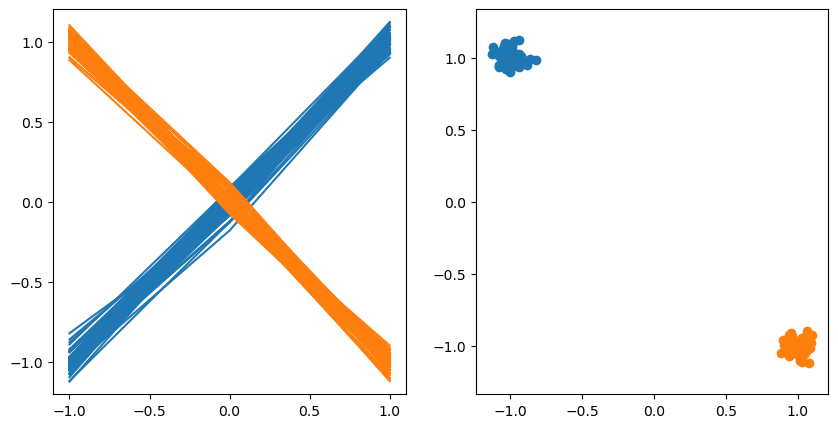

In [2]:
# Plot the trajectory and its datapoint on R^T space
def get_data(num_trajectories):
        
    # print(f"[ environments/maze2d ] getting dataset for {dataname}")
    
    # dataset = collections.defaultdict(list)            
    # for key in ['observations', 'actions', 'rewards', 'terminals', 'info/goal', 'info/qpos', 'info/qvel']:
    #     dataset[key] = []
    
    intersection_point = [[-3.33, 0], [3.33, 0]]
    # intersection_point = [[0, 0]]

    ratio = np.linspace(0, 1, 3)
    
    scale = 0.05

    start_loc_org = np.array([-1, -1], dtype=float)
    target_loc_org = np.array([1, 1], dtype=float)
    
    trajectories_lst = []
    for _ in range(num_trajectories//2):
        ref_trjectory = get_ref_trajectory(start_loc_org, target_loc_org, intersection_point, ratio, scale=scale)
        trajectories_lst.append(ref_trjectory)

    start_loc_org = np.array([-1, 1], dtype=float)
    target_loc_org = np.array([1, -1], dtype=float)
    
    for _ in range(num_trajectories//2):
        ref_trjectory = get_ref_trajectory(start_loc_org, target_loc_org, intersection_point, ratio, scale=scale)
        trajectories_lst.append(ref_trjectory)
        
    start_loc_org = np.array([-1, 0], dtype=float)
    target_loc_org = np.array([1, 0], dtype=float)
    
    # for _ in range(num_trajectories//3):
    #     ref_trjectory = get_ref_trajectory(start_loc_org, target_loc_org, intersection_point, ratio, scale=scale)
    #     trajectories_lst.append(ref_trjectory)

    trajectories = np.stack(trajectories_lst)[:, :, 1]
    
    return trajectories

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

trajectories = get_data(128)
print(trajectories.shape)

x = np.repeat(np.expand_dims(np.linspace(-1, 1, trajectories.shape[1]), axis=0), [trajectories.shape[0]], axis=0)
ax[0].plot(x[:trajectories.shape[0]//2, :].T, trajectories[:trajectories.shape[0]//2, :].T, c='tab:blue');
ax[0].plot(x[trajectories.shape[0]//2:, :].T, trajectories[trajectories.shape[0]//2:, :].T, c='tab:orange');
ax[0].axis('equal');

def extract_dimension(array, dim_lst):
    return array[:, dim_lst]

trajectories = extract_dimension(trajectories, [0, -1])
ax[1].scatter(trajectories[:trajectories.shape[0]//2, 0], trajectories[:trajectories.shape[0]//2, 1])
ax[1].scatter(trajectories[trajectories.shape[0]//2:, 0], trajectories[trajectories.shape[0]//2:, 1])
ax[1].axis('equal');

In [3]:
# LangevinSampler
import torch

class LangevinSampler:
    """Langevin Monte Carlo Sampler"""
    def __init__(self, n_step, stepsize, noise_std):
        self.n_step = n_step
        self.stepsize = stepsize
        self.noise_std = noise_std

    def sample_from_score(self, x_init, score_fn):
        x = x_init
        for i_step in range(self.n_step):
            score = score_fn(x)
            x = x + self.stepsize * score + np.random.randn(*x.shape) * self.noise_std
        return x

In [60]:
# Bring LangevinSampler
langevin_sampler = LangevinSampler(n_step=1000, stepsize=0.01, noise_std=0.1)

def get_gaussian_score_function(gmm):
    
    def get_score(x):

        n_batch = x.shape[0]

        subtract_vec = np.tile(np.expand_dims(x, axis=1), (1, 2, 1)) - np.tile(np.expand_dims(gmm.means_, axis=0), (n_batch, 1, 1) )#[batch, n_com, trajectory time step]
        prob_grad = np.einsum('ijk, bik -> bij', -gmm.precisions_, subtract_vec) #[batch, n_component, data_dim]
        weight = gmm.predict_proba(x) #[batch, n_compoent]
        weighted_prob_grad = np.einsum('bi , bij -> bij', weight, prob_grad)
        weighted_prob_grad = weighted_prob_grad.sum(axis=1)

        return weighted_prob_grad

    return get_score
        

In [73]:
from sklearn.mixture import GaussianMixture
# Plot score

scale = 0.1
a = np.random.multivariate_normal([2, 2, 2], [[scale, 0, 0], [0, scale, 0], [0, 0, scale]], 512)
b = -np.random.multivariate_normal([2, 2, 2], [[scale, 0, 0], [0, scale, 0], [0,0, scale]], 512)

data = np.concatenate([a, b])

gmm = GaussianMixture(n_components=2, random_state=0).fit(data)

score_fn = get_gaussian_score_function(gmm)

# a = np.random.multivariate_normal([2, 2], [[scale, 0], [0, scale]], 50)
# b = -np.random.multivariate_normal([2, 2], [[scale, 0], [0, scale]], 50)

# data = np.concatenate([a, b])

# x_lim = [-5, 5]
# y_lim = [-5, 5]

# x_grid, y_grid = np.meshgrid(np.linspace(*x_lim, 15), np.linspace(*y_lim, 15))

# grid_input = np.stack([x_grid, y_grid], axis=-1).reshape((-1, 2))

# score_vec = score_fn(grid_input).reshape(( *x_grid.shape[0:2], 2))

x_init = np.random.randn(100, 3)
sampled_point = langevin_sampler.sample_from_score(x_init, score_fn)
print(sampled_point)

# plt.scatter(data[:, 0], data[:, 1])
# plt.scatter(sampled_point[:, 0], sampled_point[:, 1])
# plt.quiver(x_grid, y_grid, score_vec[:, :, 0], score_vec[:, :, 1])
# plt.xlim(*x_lim)
# plt.ylim(*y_lim)
# plt.axes().set_aspect('equal')

[[ 2.18227578  1.96903939  2.10969159]
 [-2.04594422 -2.17377192 -2.02915348]
 [-2.33996545 -2.24154547 -2.16322433]
 [ 1.65985023  1.83517842  1.84344484]
 [ 1.86670321  1.69449525  1.75077685]
 [-1.68676579 -1.9890492  -2.18499859]
 [-2.16067695 -1.99031707 -1.62578132]
 [-2.35745291 -2.14660903 -1.72227137]
 [ 1.87532097  2.31607291  2.25768917]
 [-1.92433307 -1.89369482 -2.01425219]
 [ 2.4232598   1.59782288  2.25439196]
 [-1.61060319 -1.85398214 -2.1164477 ]
 [ 2.10400741  1.63734958  1.70579518]
 [-1.95039894 -1.9228138  -1.71404558]
 [ 2.30317034  1.91868502  1.79931005]
 [ 2.00245036  1.45920941  1.83420909]
 [-2.01584655 -1.9808441  -1.8342409 ]
 [ 1.99829499  1.9172632   1.79222289]
 [-1.67628107 -1.82240938 -1.90216543]
 [-1.8312529  -2.11118043 -1.84874162]
 [-1.7341871  -1.8444115  -1.6722504 ]
 [-2.32008193 -1.72952406 -1.96577707]
 [ 2.24082167  1.72777273  1.56799137]
 [-2.29602816 -1.84238113 -1.77964157]
 [ 1.71250048  1.63266739  1.64899095]
 [-1.90714719 -1.8216202 

In [71]:
# Fit trajectory purely via GMM
from sklearn.mixture import GaussianMixture

n_components = 2
n_trajectories = 1024
trajectories = get_data(n_trajectories)
gmm = GaussianMixture(n_components=n_components, random_state=0).fit(trajectories)

# # print(np.zeros_like(trajectories) - gmm.means_)
# subtract_vec = np.tile(np.expand_dims(trajectories, axis=1), (1, 2, 1)) - np.tile(np.expand_dims(gmm.means_, axis=0), (n_trajectories, 1, 1) )#[batch, n_com, trajectory time step]

# # print(f"="*10)
# prob_grad = np.einsum('ijk, bik -> bij', -gmm.precisions_, subtract_vec) #[batch, n_component, data_dim]

# # get weight
# # print("="*10)
# weight = gmm.predict_proba(trajectories) #[batch, n_compoent]
# # print(weight)
# weighted_prob_grad = np.einsum('bi , bij -> bij', weight, prob_grad)
# # print(weighted_prob_grad)
# weighted_prob_grad = weighted_prob_grad.sum(axis=1)

x_init = np.random.randn(*trajectories.shape)
print(x_init.shape)

x = langevin_sampler.sample_from_score(x_init, get_gaussian_score_function(gmm))

(1024, 3)


/home/cspark/anaconda3/envs/diffuser/lib/python3.8/site-packages/sklearn/mixture/_gaussian_mixture.py:427: RuntimeWarning: overflow encountered in square
  log_prob[:, k] = np.sum(np.square(y), axis=1)
/home/cspark/anaconda3/envs/diffuser/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cspark/anaconda3/envs/diffuser/lib/python3.8/site-packages/sklearn/mixture/_base.py:527: RuntimeWarning: invalid value encountered in subtract
  log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]


ValueError: Input X contains NaN.
GaussianMixture does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
from sklearn.mixture import GaussianMixture

# Bring Gaussian Mixture model
dummy_data = get_data(1)
T = dummy_data.shape[1]

n_components = 2
joint_dist_GMM_lst = [GaussianMixture(n_components=n_components, random_state=0) for _ in range(T-1)]
marginal_dist_GMM_lst = [GaussianMixture(n_components=n_components, random_state=0) for _ in range(T-1)]

# Bring LangevinSampler
langevin_sampler = LangevinSampler(n_step=1000, stepsize=0.01, noise_std=0.05)

In [ ]:
# Train GMM model

trajectories = get_data(1024)

for t, (joint_dist_GMM, marginal_dist_GMM) in enumerate(zip(joint_dist_GMM_lst, marginal_dist_GMM_lst)):
    joint_dist_GMM.fit(trajectories[:, [t, t+1]])
    marginal_dist_GMM.fit(trajectories[:, [t]])

In [ ]:
# Train score model
from tqdm import tqdm

sigma = 0.1
batch_size = 128
training_step = 10000

stitch_loss_lst = []

stitch_loss_lst_lst = []
stitch_sampled_trajectories_lst = []



for i in tqdm(range(training_step)):
    opt.zero_grad()

    # get noised data
    train_data = torch.from_numpy(get_data(batch_size)).to(dtype=torch.float32).to(device=device)
    T = train_data.shape[1]
    noise_z = np.random.multivariate_normal(np.zeros(train_data.shape[1]), cov=np.eye(train_data.shape[1]), size=train_data.shape[0])
    noise_z = torch.tensor(noise_z, dtype=torch.float).to(device=device)
    train_data_noise = train_data + sigma * noise_z
    
    loss = 0
    
    time = torch.arange(T-1).repeat(train_data.shape[0]).unsqueeze(1).to(device=device)
    joint_energy_model_input = torch.stack([train_data_noise[:, :-1], train_data_noise[:, 1:]], dim=-1).reshape(-1, 2).requires_grad_()
    joint_energy = joint_energy_model(joint_energy_model_input, time)
    joint_score = -grad(joint_energy.sum(), joint_energy_model_input, create_graph=True)[0]
    joint_noise = torch.stack([noise_z[:, :-1], noise_z[:, 1:]], dim=-1).reshape(-1, 2)
    joint_loss = torch.norm(joint_noise/sigma + joint_score, dim=-1)**2
    loss += 1/2 * joint_loss.mean()
    
    marginal_energy_input = train_data_noise[:, :-1].reshape(-1, 1).requires_grad_()
    marginal_energy = marginal_energy_model(marginal_energy_input, time)
    marginal_score = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0]
    marginal_noise = noise_z[:, :-1].reshape(-1, 1)
    marginal_loss = torch.norm(marginal_noise/sigma + marginal_score, dim=-1)**2
    loss += 1/2 * marginal_loss.mean()
    
    loss.backward()
    opt.step()
    stitch_loss_lst.append(loss.clone().detach().cpu().item())
    
    if i % (training_step//5) == 0:
        stitch_loss_lst_lst.append(stitch_loss_lst.copy())

        ## sample data
        x0 = torch.randn_like(train_data)
        
        def get_score(x):
            batch_size = x.shape[0]
            T = x.shape[1]
            
            total_score = torch.zeros_like(x).to(x.device)
            
            time = torch.arange(T-1).repeat(batch_size).unsqueeze(1).to(device=device)
            
            joint_energy_model_input = torch.stack([x[:, :-1], x[:, 1:]], dim=-1).reshape(batch_size * (T-1), 2).requires_grad_()
            joint_energy = joint_energy_model(joint_energy_model_input, time)
            joint_score = -grad(joint_energy.sum(), joint_energy_model_input, create_graph=True)[0].reshape(batch_size, -1, 2)
            
            total_score[:, :-1] += joint_score[:, :, 0]
            total_score[:, 1:] += joint_score[:, :, 1]
            
            marginal_energy_input = x[:, :-1].reshape(batch_size * (T-1), 1).clone().requires_grad_()
            marginal_energy = marginal_energy_model(marginal_energy_input, time)
            marginal_score = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0].reshape(batch_size, -1)
            
            total_score[:, 1:-1] -= marginal_score[:, 1:]
            
            return total_score.detach()
        
        stitch_sampled_trajectories = langevin_sampler.sample_from_score(x0, get_score)
        stitch_sampled_trajectories_lst.append(stitch_sampled_trajectories.clone().detach().cpu().numpy())

In [ ]:
plt.plot(stitch_loss_lst_lst[-1])

In [ ]:
# Plot the sampled trajectory and its datapoit on R^T space
fig, ax = plt.subplots(len(stitch_loss_lst_lst), 3, figsize=(15, 5*len(stitch_loss_lst_lst)))

for i, (loss_lst, sampled_trajectories) in enumerate(zip(stitch_loss_lst_lst, stitch_sampled_trajectories_lst)):

    num = 0
    x = np.repeat(np.expand_dims(np.linspace(-1, 1, sampled_trajectories.shape[1]), axis=0), [sampled_trajectories.shape[0]], axis=0)[num:]
    trajectories = get_data(sampled_trajectories.shape[0])[num:]
    sampled_trajectories = sampled_trajectories[num:]

    ax[i, 0].plot(x.T, trajectories.T, c='tab:blue');
    ax[i, 0].plot(x.T, sampled_trajectories.T, c='tab:orange');
    # ax[i, 0].axis('equal')
    # ax[i, 0].set_xlim(-1.5, 1.5)
    # ax[i, 0].set_ylim(-1.5, 1.5)
    axis = [0, -1]
    
    sampled_trajectories_ = extract_dimension(sampled_trajectories, axis)
    trajectories_ = extract_dimension(trajectories, axis)

    ax[i, 1].scatter(trajectories_[:, 0], trajectories_[:, 1])
    ax[i, 1].scatter(sampled_trajectories_[:, 0], sampled_trajectories_[:, 1])
    # ax[i, 1].axis('equal')
    # ax[i, 1].set_xlim(-1.5, 1.5)
    # ax[i, 1].set_ylim(-1.5, 1.5)
    
    ax[i, 2].plot(loss_lst)


In [ ]:
x = np.repeat(np.expand_dims(np.linspace(-1, 1, sampled_trajectories.shape[1]), axis=0), [sampled_trajectories.shape[0]], axis=0)
n = int(np.random.uniform(0, len(sampled_trajectories)))
plt.plot(x.T, trajectories.T, c='tab:blue');
plt.plot(x[0], sampled_trajectories[n], c='tab:orange');
plt.title(n);

In [ ]:
# Plot sampled trajectory
x0 = torch.randn_like(train_data)[:100]

langevin_sampler = LangevinSampler(n_step=5000, stepsize=0.01, noise_std=0.05)

def get_score(x):
    batch_size = x.shape[0]
    T = x.shape[1]
    
    total_score = torch.zeros_like(x).to(x.device)
    
    time = torch.arange(T-1).repeat(batch_size).unsqueeze(1).to(device=device)
    
    joint_energy_model_input = torch.stack([x[:, :-1], x[:, 1:]], dim=-1).reshape(batch_size * (T-1), 2).requires_grad_()
    joint_energy = joint_energy_model(joint_energy_model_input, time)
    joint_score = -grad(joint_energy.sum(), joint_energy_model_input, create_graph=True)[0].reshape(batch_size, -1, 2)
    
    total_score[:, :-1] += joint_score[:, :, 0]
    total_score[:, 1:] += joint_score[:, :, 1]
    
    marginal_energy_input = x[:, :-1].reshape(batch_size * (T-1), 1).clone().requires_grad_()
    marginal_energy = marginal_energy_model(marginal_energy_input, time)
    marginal_score = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0].reshape(batch_size, -1)
    
    total_score[:, 1:-1] -= marginal_score[:, 1:]
    
    return total_score.detach()

stitch_sampled_trajectories = langevin_sampler.sample_from_score(x0, get_score).detach().cpu().numpy()

plt.plot(x.T, trajectories.T, c='tab:blue');
plt.plot(x[:x0.shape[0]].T, stitch_sampled_trajectories.T, c='tab:orange');

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

trajectories = get_data(128)

# Bring LangevinSampler
langevin_sampler_validate = LangevinSampler(n_step=1000, stepsize=0.01, noise_std=0.05)
T = trajectories.shape[1]

fig, ax = plt.subplots(T-1, 4, figsize=(20, 5* (T-1)))

for t in tqdm(range(T-1)):

    trajectories_slice = trajectories[:, [t, t+1]]

    # sample data
    x0 = torch.randn_like(torch.tensor(trajectories_slice, dtype=torch.float32)).to(device=device)

    def get_joint_score(x):
        batch_size = x.shape[0]
        time = torch.tensor(t).repeat(batch_size).unsqueeze(1).to(device=device)
        
        joint_energy_model_input = x.clone().requires_grad_()
        joint_energy = joint_energy_model(joint_energy_model_input, time)
        joint_score = -grad(joint_energy.sum(), joint_energy_model_input, create_graph=True)[0]

        return joint_score.clone().detach()

    def get_marginal_score(x):
        batch_size = x.shape[0]
        time = torch.tensor(t).repeat(batch_size).unsqueeze(1).to(device=device)
        
        marginal_energy_input = x.clone().requires_grad_()
        marginal_energy = marginal_energy_model(marginal_energy_input, time)
        marginal_score = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0]

        return marginal_score.clone().detach()

    sampled_joint_datapoint = langevin_sampler_validate.sample_from_score(x0, get_joint_score).clone().detach().cpu().numpy()

    sampled_marginal_datapoint = langevin_sampler_validate.sample_from_score(x0[:, 0:1], get_marginal_score).clone().detach().cpu().numpy()
    
    joint_kmeans_idx = GaussianMixture(n_components=2).fit_predict(sampled_joint_datapoint)
    marginal_kmeans_idx = GaussianMixture(n_components=2).fit_predict(sampled_marginal_datapoint)

    x_lim = [-1.5, 1.5]
    y_lim = [-1.5, 1.5]
    x_grid, y_grid = np.meshgrid(np.linspace(*x_lim, 15), np.linspace(*y_lim, 15))
    
    grid_input = torch.tensor(np.stack([x_grid, y_grid], axis=-1).reshape((-1, 2)), dtype=torch.float32, device=device)
    score = get_joint_score(grid_input).reshape((*x_grid.shape, 2)).cpu().numpy()
    ax[t][0].scatter(trajectories_slice[:, 0], trajectories_slice[:, 1], c='tab:blue')
    ax[t][0].scatter(sampled_joint_datapoint[np.where(joint_kmeans_idx == 0), 0], sampled_joint_datapoint[np.where(joint_kmeans_idx == 0), 1], c='tab:orange')
    ax[t][0].scatter(sampled_joint_datapoint[np.where(joint_kmeans_idx == 1), 0], sampled_joint_datapoint[np.where(joint_kmeans_idx == 1), 1], c='tab:green')
    ax[t][0].quiver(x_grid, y_grid, score[:, :, 0], score[:, :, 1])
    ax[t][0].set_ylabel(f"{t}")
    # ax[t][0].set_xlim(*x_lim)
    # ax[t][0].set_ylim(*y_lim)
    
    grid_input = torch.tensor(np.stack([x_grid, y_grid], axis=-1).reshape((-1, 2)), dtype=torch.float32, device=device)
    score = get_marginal_score(grid_input[:, 0:1]).reshape((*x_grid.shape, 1)).cpu().numpy()
    ax[t][1].scatter(trajectories_slice[:, 0], trajectories_slice[:, 0], c='tab:blue')
    ax[t][1].scatter(sampled_marginal_datapoint[np.where(marginal_kmeans_idx == 0), 0], sampled_marginal_datapoint[np.where(marginal_kmeans_idx == 0), 0], c='tab:orange')
    ax[t][1].scatter(sampled_marginal_datapoint[np.where(marginal_kmeans_idx == 1), 0], sampled_marginal_datapoint[np.where(marginal_kmeans_idx == 1), 0], c='tab:green')
    ax[t][1].quiver(x_grid, y_grid, score[:, :, 0], np.zeros_like(score[:, :, 0]))
    # ax[t][1].set_xlim(*x_lim)
    # ax[t][1].set_ylim(*y_lim)
    
    ax[t][2].hist(joint_kmeans_idx, alpha=0.3)
    ax[t][3].hist(marginal_kmeans_idx, alpha=0.3)
    
plt.show()

In [ ]:
a = np.array([[1,2],[3,4], [5,6]])
a[[0, 2], :]